In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle
import pqcd

from cmcrameri import cm
from scipy.stats import gaussian_kde
from scipy.interpolate import PchipInterpolator
from matplotlib.colors import ListedColormap
from pqcd.utils import (
    to_GeV_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )

from plot_utils import (
    rcparams,
    xlim_pe,
    ylim_pe
)
plt.rcParams.update(rcparams)

rng = np.random.default_rng()

In [2]:
collated_eos_path = '../data/eos-draws-default/eos-draws-default.csv'
collated_eos = pd.read_csv(collated_eos_path, index_col=0)

# pQCD posterior

In [3]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

muH = 2.6
mu_array = np.linspace(muL, muH, 1000)

### KDE on EOS extensions

In [4]:
# Define the number of colors in the colormap
ncolors = 256

# Create an array for RGBA values
colors = np.zeros((ncolors, 4))

# Set RGB values to 0 (black)
colors[:, 0] = 0  # Red channel
colors[:, 1] = 0  # Green channel
colors[:, 2] = 0  # Blue channel

# Set alpha values to transition from 0 (transparent) to 1 (opaque)
colors[:, 3] = np.linspace(0, 1, ncolors)

# Create the custom colormap
transparent_to_black = ListedColormap(colors, name='TransparentToBlack')

In [5]:
# EOS extension KDE

n0 = 10*nsat

with open(
    '../data/eos-extensions/eos_extensions_'
    's-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 
    'rb'
    ) as f:
    eos_extensions = pickle.load(f)

eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

e_kde = []
p_kde = []
for index, eos in eos_extensions.iterrows():
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    e_kde.append(eos.e[highlight_index])
    p_kde.append(eos.p[highlight_index])

e_kde = np.array(e_kde)
p_kde = np.array(p_kde)

# Stack the data into a 2D array
data = np.vstack([e_kde, p_kde])

# Create the KDE
kde = gaussian_kde(data)

# Generate a grid over which to evaluate the KDE
x_min, x_max = xlim_pe[0], xlim_pe[1]
y_min, y_max = ylim_pe[0], ylim_pe[1]
X, Y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

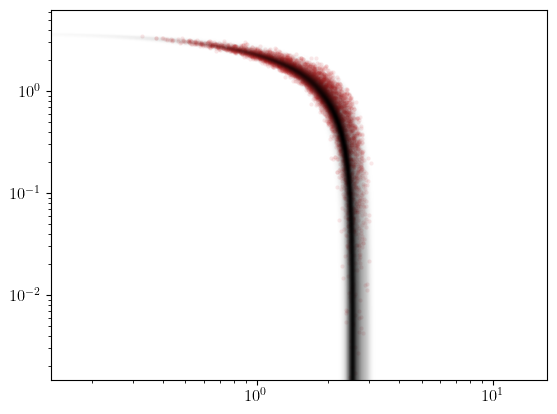

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_kde, p_kde, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.1)
ax.imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=2,
    alpha=1
);

In [7]:
e_10nsat = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_10nsat.dat'
)
p_10nsat = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_10nsat.dat'
)

mask = ~np.logical_or(np.isnan(e_10nsat), np.isnan(p_10nsat))
e_10nsat = e_10nsat[mask]
p_10nsat = p_10nsat[mask]

sample = rng.choice(len(e_10nsat), size=10000, replace=False)
e_10nsat = e_10nsat[sample]
p_10nsat = p_10nsat[sample]

### Inspect EOS prior at $10n_\mathrm{sat}$

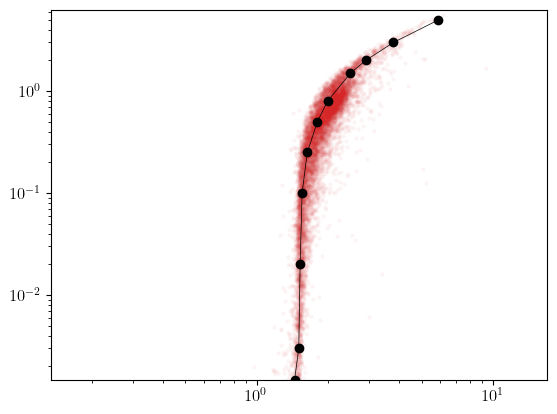

In [8]:
fig, ax = plt.subplots()
ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_10nsat, p_10nsat, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.05)

x_fit = [1.45, 1.51, 1.53, 1.56, 1.64, 1.81, 2.0, 2.5, 2.9, 3.8, 5.9]
y_fit = [ylim_pe[0], 3e-3, 2e-2, 1e-1, 2.5e-1, 5e-1, 8e-1, 1.5, 2, 3, 5]
ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='k');

In [9]:
x_fit_dense_10nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_10nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_10nsat)

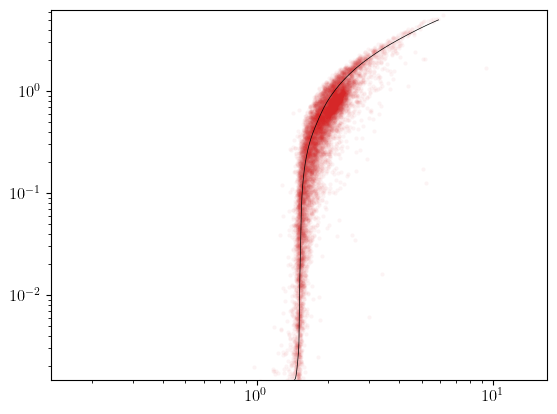

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_10nsat, p_10nsat, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.05)
ax.plot(x_fit_dense_10nsat, y_fit_dense_10nsat, lw=0.5, c='k');

In [11]:
def plot_quantiles(ax, quantiles, x_pe, c, ls, lw, x_cut, y_cut, 
                   fill_alpha=0.25, alpha_scale=0.25, line_zorder=1.2, 
                   fill_zorder=0.8):

    y_fit_interp = np.interp(x_pe, x_cut, y_cut, left=-100)

    q5 = quantiles.loc[5,:].values
    q95 = quantiles.loc[95,:].values

    i1 = np.argmin((q5 - y_fit_interp)**2)
    i2 = np.argmin((q95 - y_fit_interp)**2)

    # Full opacity

    ax.fill_between(
        x_pe[:i1], 
        q5[:i1], 
        q95[:i1], 
        color=list(c)[:3]+[fill_alpha], 
        edgecolor=c,
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[:i1],
        q5[:i1],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    ax.plot(
        x_pe[:i1],
        q95[:i1],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    # Intermediate upper

    ax.fill_between(
        x_pe[i1-1:i2], 
        y_fit_interp[i1-1:i2], 
        q95[i1-1:i2], 
        color=list(c)[:3] + [fill_alpha], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i1:i2],
        q95[i1:i2],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    # Intermediate lower

    ax.fill_between(
        x_pe[i1-1:i2], 
        q5[i1-1:i2], 
        y_fit_interp[i1-1:i2],
        color=list(c)[:3] + [fill_alpha*alpha_scale], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i1:i2],
        q5[i1:i2],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

    # Low opacity

    ax.fill_between(
        x_pe[i2:], 
        q5[i2:], 
        q95[i2:], 
        color=list(c)[:3] + [fill_alpha*alpha_scale], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i2:],
        q5[i2:],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

    ax.plot(
        x_pe[i2:],
        q95[i2:],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

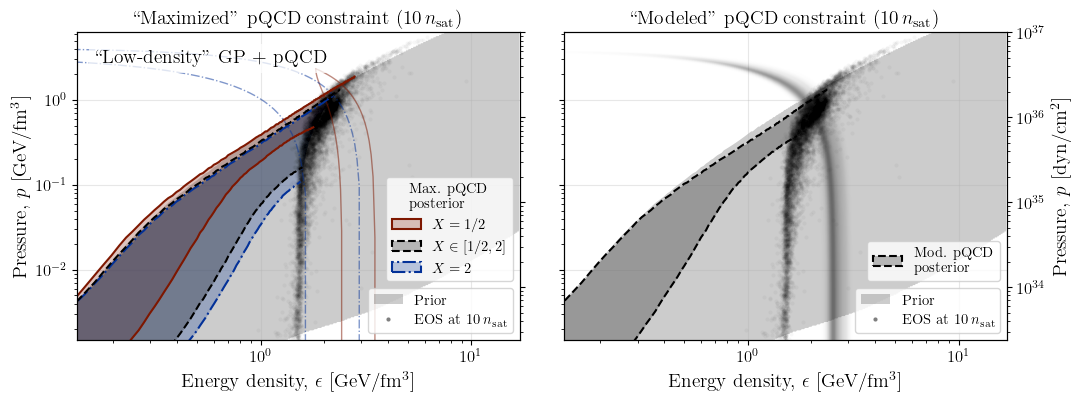

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# pQCD likelihood
# ---------------

X_list = [0.5, 2]
c_list = [cm.roma(0.), cm.roma(1.)]
ls_list = ['-', '-.']

# Maximized

for i, X in enumerate(X_list):

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)

    mu0 = np.linspace((n0/nH)*muH, muH, num=100)

    p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
    epsilon0_min = mu0*n0 - p0_min

    p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
    epsilon0_max = mu0*n0 - p0_max

    alpha = 0.5
    ls = ls_list[i]
    c = c_list[i]
    zorder = 1
    lw = 1

    if X == 0.5:
        axs[0].plot(
            epsilon0_min, 
            p0_min, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )
        axs[0].plot(
            epsilon0_max, 
            p0_max, 
            c=c,
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )

    if X == 2:
        axs[0].plot(
            epsilon0_min, 
            p0_min, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )
        axs[0].plot(
            epsilon0_max, 
            p0_max, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )

# Marginalized

axs[1].imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=1,
    alpha=0.5
)

# GP posteriors
# -------------

# Max

lw = 1.5

for i, X in enumerate(X_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_X{X}_mu2.6.csv'
        )
    )

    plot_quantiles(
        axs[0], 
        quantiles,
        x_pe,
        c=c_list[i],
        ls=ls_list[i],
        lw=lw,
        x_cut=x_fit_dense_10nsat,
        y_cut=y_fit_dense_10nsat,
        alpha_scale=0
    )
    
quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/'
        f'p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_Xmarg_mu2.6.csv'
    )
)

plot_quantiles(
    axs[0], 
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dense_10nsat,
    y_cut=y_fit_dense_10nsat,
    alpha_scale=0
)

# Marg

c = [0,0,0]

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/'
        f'p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_marg.csv'
    )
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dense_10nsat,
    y_cut=y_fit_dense_10nsat,
    alpha_scale=0
)

# GP prior at 10nsat
# ------------------

for ax in axs:
    ax.plot(
        e_10nsat, 
        p_10nsat, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.03, 
        markeredgewidth=0,
        zorder=0.9,
        rasterized=True
    )

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_list[0])[:3]+[0.25],
        edgecolor=c_list[0],
        lw=1.5,
        linestyle=ls_list[0]
    ),
    mpatches.Patch(
        facecolor=[0,0,0,0.25], 
        edgecolor='k', 
        fill=True, 
        lw=1.5, 
        linestyle='--'
    ),
    mpatches.Patch(
        facecolor=list(c_list[1])[:3]+[0.25],
        edgecolor=c_list[1],
        lw=1.5,
        linestyle=ls_list[1]
    ),
]

custom_labels = [
    '$X = 1/2$',
    '$X \in [1/2,2]$',
    '$X = 2$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='Max. pQCD\nposterior', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.17))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(
        facecolor=[0,0,0,0.25], 
        edgecolor='k', 
        fill=True, 
        lw=1.5, 
        linestyle='--')
]

custom_labels = [
    'Mod. pQCD\nposterior'
]

l2 = axs[1].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    fontsize=10.5,
    bbox_to_anchor=(1,0.17)
)

axs[1].add_artist(l2)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Prior',
    'EOS at $10\,n_\mathrm{sat}$',
]

for ax in axs:
    ax.legend(
        custom_handles,
        custom_labels,
        loc='lower right',
        fontsize=10.5
    )

# ---

axs[0].text(
    0.04, 
    0.9, 
    "``Low-density'' GP + pQCD", 
    transform=axs[0].transAxes,
    # add background
    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($10\,n_\mathrm{sat}$)')
axs[1].set_title('``Modeled" pQCD constraint ($10\,n_\mathrm{sat}$)')

fig.savefig('figures/paper/pqcd_e_p_posterior_10nsat.pdf', bbox_inches='tight', dpi=300)

In [13]:
e_ntov = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)
p_ntov = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)

In [14]:
e_ntov = e_ntov[collated_eos.logweight_total > -np.inf]
p_ntov = p_ntov[collated_eos.logweight_total > -np.inf]

mask = ~np.logical_or(np.isnan(e_ntov), np.isnan(p_ntov))

e_ntov = e_ntov[mask]
p_ntov = p_ntov[mask]

len(e_ntov), len(p_ntov)

(79600, 79600)

In [15]:
sample = rng.choice(len(e_ntov), size=5000, replace=False)

e_ntov = e_ntov[sample]
p_ntov = p_ntov[sample]

In [16]:
x_fit = [0.7, 1, 1.5, 2, 3]
y_fit = [0.115, 0.24, 0.6, 1.3, 3.5]

x_fit_dense_ntov = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_ntov = PchipInterpolator(x_fit, y_fit)(x_fit_dense_ntov)

In [17]:
x_fit_extended = [0.4, 0.5, 0.7, 1, 1.5, 2, 3]
y_fit_extended = [0.043, 0.06, 0.115, 0.24, 0.6, 1.3, 3.5]

x_fit_dense_ntov_extended = np.linspace(x_fit_extended[0], x_fit_extended[-1], 1000)
y_fit_dense_ntov_extended = PchipInterpolator(x_fit_extended, y_fit_extended)(x_fit_dense_ntov_extended)

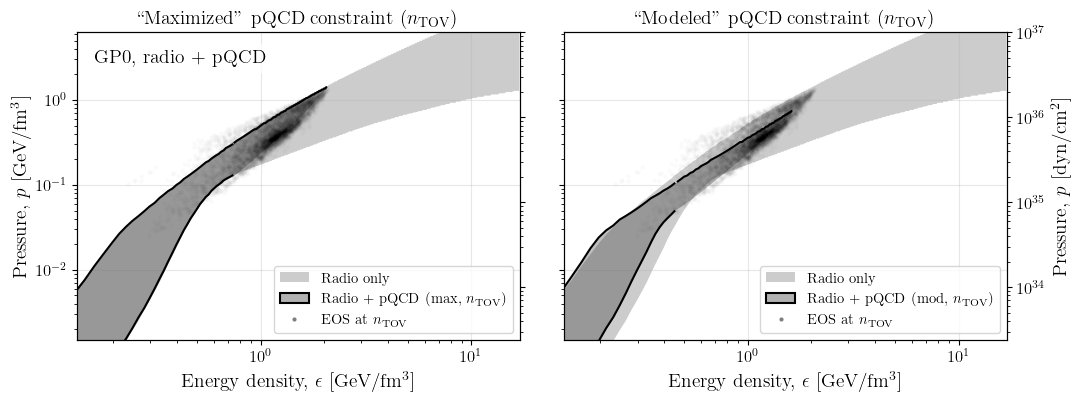

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# Radio only
# ----------

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio.csv')
)

q5 = quantiles.loc[5,:].values
q95 = quantiles.loc[95,:].values

for ax in axs:
    ax.fill_between(
        x_pe,
        q5,
        q95,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

ntov_c = 'k'
lw = 1.5

# Max

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio_pqcd_ntov_Xmarg_mu2.6.csv')
)

plot_quantiles(
    axs[0], 
    quantiles,
    x_pe,
    c=[0.,0.,0.],
    ls='-',
    lw=lw,
    x_cut=x_fit_dense_ntov,
    y_cut=y_fit_dense_ntov,
    alpha_scale=0,
    fill_alpha=0.25
)

# Marg

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio_pqcd_ntov_marg.csv')
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0.,0.,0.],
    ls='-',
    lw=lw,
    x_cut=x_fit_dense_ntov_extended,
    y_cut=y_fit_dense_ntov_extended,
    alpha_scale=0,
    fill_alpha=0.25
)

# GP prior at nTOV
# ----------------

for ax in axs:
    ax.plot(
        e_ntov, 
        p_ntov, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.02, 
        markeredgewidth=0,
        zorder=0.9,
        rasterized=True
    )

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    mpatches.Patch(edgecolor=ntov_c, linewidth=lw, facecolor= [0.6, 0.6, 0.6, 0.75]),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Radio only',
    'Radio + pQCD (max, $n_\mathrm{TOV}$)',
    'EOS at $n_\mathrm{TOV}$',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

custom_labels = [
    'Radio only',
    'Radio + pQCD (mod, $n_\mathrm{TOV}$)',
    'EOS at $n_\mathrm{TOV}$',
]

axs[1].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(
    0.04, 
    0.9, 
    'GP0, radio + pQCD', 
    transform=axs[0].transAxes,
    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($n_\mathrm{TOV}$)')
axs[1].set_title('``Modeled" pQCD constraint ($n_\mathrm{TOV}$)')

fig.savefig('figures/paper/radio_pqcd_e_p_posterior_ntov.pdf', bbox_inches='tight', dpi=300)

In [19]:
nterm_list = [4,6,8]

e_nterm_dict = {}
p_nterm_dict = {}

for nterm in nterm_list:

    e_nterm = np.loadtxt(
        f'../data/eos-draws-default/quantities_at_n/energy_density_{nterm:02}nsat.dat'
    )
    p_nterm = np.loadtxt(
        f'../data/eos-draws-default/quantities_at_n/pressure_{nterm:02}nsat.dat'
    )

    mask = ~np.logical_or(np.isnan(e_nterm), np.isnan(p_nterm))
    e_nterm = e_nterm[mask]
    p_nterm = p_nterm[mask]

    sample = rng.choice(len(e_nterm), size=10000, replace=False)
    e_nterm = e_nterm[sample]
    p_nterm = p_nterm[sample]

    e_nterm_dict[nterm] = e_nterm
    p_nterm_dict[nterm] = p_nterm

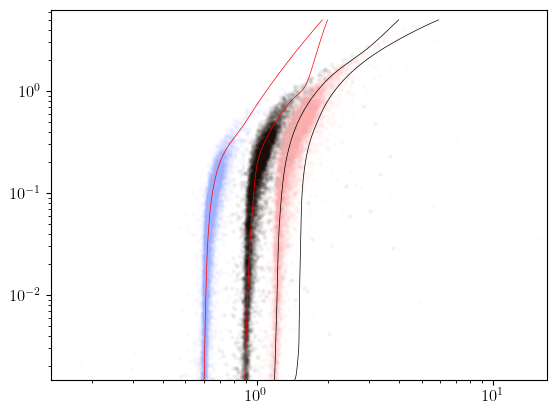

In [20]:
c_dict = {
    nterm: cm.berlin(i/(len(nterm_list)-1)) for i, nterm in enumerate(nterm_list)
}

fig, ax = plt.subplots()
ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe)
ax.set_xscale('log')
ax.set_yscale('log')

for i, nterm in enumerate(nterm_list):

    c = c_dict[nterm]

    ax.plot(
        e_nterm_dict[nterm], 
        p_nterm_dict[nterm], 
        lw=0, 
        marker='.', 
        markeredgewidth=0, 
        c=c, 
        alpha=0.05
    )

# 8nsat
x_fit = [1.19, 1.215, 1.25, 1.33, 1.5, 2, 3, 4]
y_fit = [ylim_pe[0], 0.006, 0.05, 0.2, 0.5, 1.3, 2.7, 5]
x_fit_dense_8nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_8nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_8nsat)

# 6nsat
x_fit = [0.89, 0.91, 0.95, 1.01, 1.14, 1.4, 1.6, 2]
y_fit = [ylim_pe[0], 0.006, 0.05, 0.2, 0.4, 0.8, 1.1, 5]
x_fit_dense_6nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_6nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_6nsat)

# 4nsat
x_fit = [0.6, 0.61, 0.62, 0.65, 0.7, 0.9, 1.9]
y_fit = [ylim_pe[0], 0.01, 0.03, 0.1, 0.2, 0.5, 5]
x_fit_dense_4nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_4nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_4nsat)

# ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='r')

ax.plot(x_fit_dense_4nsat, y_fit_dense_4nsat, lw=0.5, c='r')
ax.plot(x_fit_dense_6nsat, y_fit_dense_6nsat, lw=0.5, c='r')
ax.plot(x_fit_dense_8nsat, y_fit_dense_8nsat, lw=0.5, c='k')
ax.plot(x_fit_dense_10nsat, y_fit_dense_10nsat, lw=0.5, c='k')

x_fit_dict = {
    4: x_fit_dense_4nsat,
    6: x_fit_dense_6nsat,
    8: x_fit_dense_8nsat,
    10: x_fit_dense_10nsat
}

y_fit_dict = {
    4: y_fit_dense_4nsat,
    6: y_fit_dense_6nsat,
    8: y_fit_dense_8nsat,
    10: y_fit_dense_10nsat
}

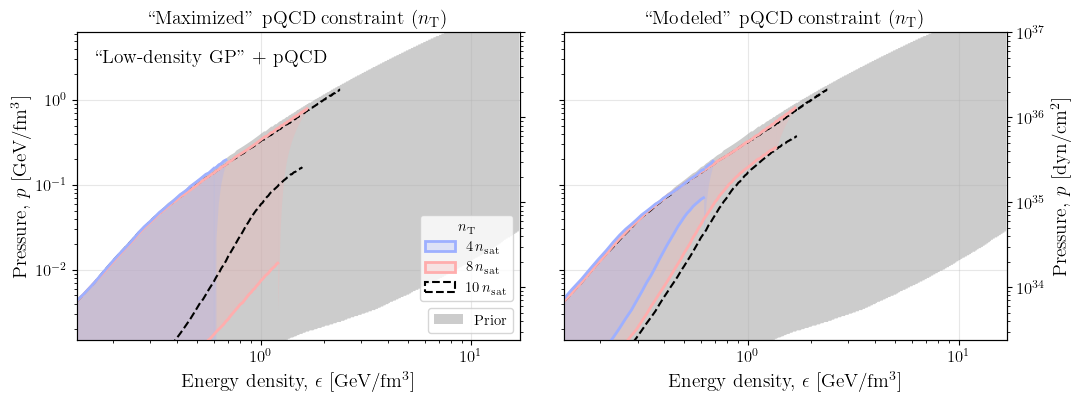

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 2

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 8,
    8: 7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv'
        )
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_marg.csv'
        )
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_Xmarg_mu2.6.csv'
    )
)

plot_quantiles(
    axs[0],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv'
    )
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=2,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4\,n_\mathrm{sat}$',
    '$8\,n_\mathrm{sat}$',
    '$10\,n_\mathrm{sat}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{T}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.105))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
]

custom_labels = [
    'Prior',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(0.04, 0.9, "``Low-density GP'' + pQCD", transform=axs[0].transAxes)

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($n_\mathrm{T}$)')
axs[1].set_title('``Modeled" pQCD constraint ($n_\mathrm{T}$)')

fig.savefig('figures/paper/pqcd_e_p_posterior_nterm.pdf', bbox_inches='tight', dpi=300)

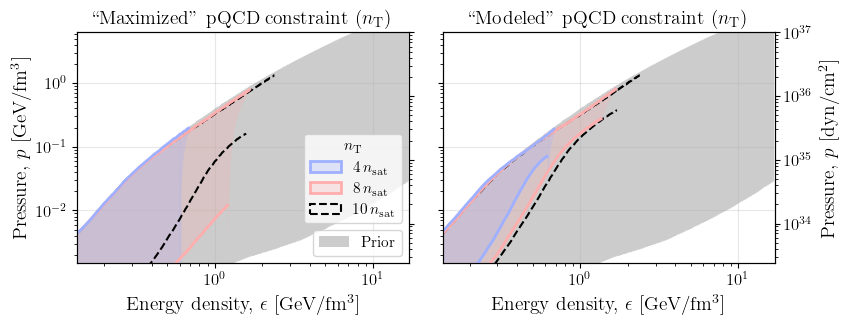

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 2

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 8,
    8: 7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv'
        )
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_marg.csv'
        )
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_Xmarg_mu2.6.csv'
    )
)

plot_quantiles(
    axs[0],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv'
    )
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=2,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4\,n_\mathrm{sat}$',
    '$8\,n_\mathrm{sat}$',
    '$10\,n_\mathrm{sat}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{T}$', 
    fontsize=11, 
    title_fontsize=11,
    bbox_to_anchor=(1,0.14))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
]

custom_labels = [
    'Prior',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=11
)

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($n_\mathrm{T}$)')
axs[1].set_title('``Modeled" pQCD constraint ($n_\mathrm{T}$)')

fig.savefig(
    'figures/presentation/pqcd_e_p_posterior_nterm.png', 
    bbox_inches='tight', 
    dpi=300
)

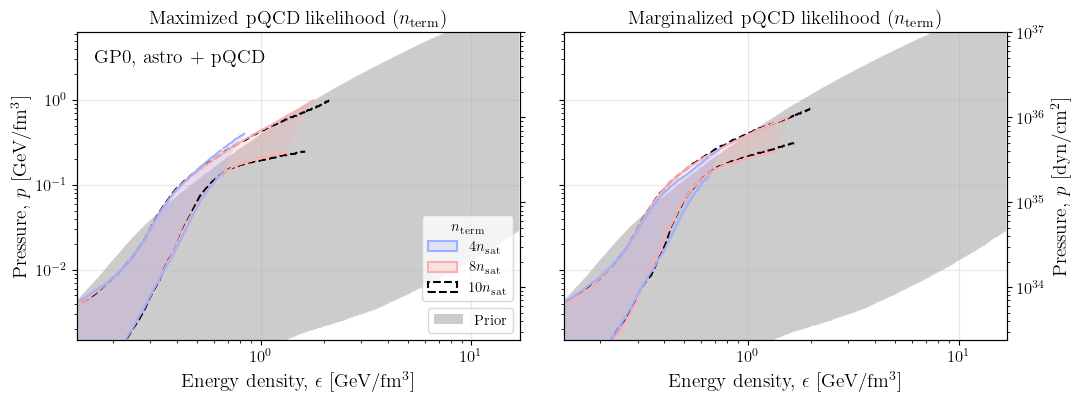

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 1.5

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 8,
    8: 7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_astro_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv'
        )
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_astro_pqcd_{int(nterm):02}nsat_marg.csv'
        )
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_Xmarg_mu2.6.csv'
    )
)

plot_quantiles(
    axs[0],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_marg.csv'
    )
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=1.5,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4n_\mathrm{sat}$',
    '$8n_\mathrm{sat}$',
    '$10n_\mathrm{sat}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{term}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.105))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
]

custom_labels = [
    'Prior',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(0.04, 0.9, 'GP0, astro + pQCD', transform=axs[0].transAxes)

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('Maximized pQCD likelihood ($n_\mathrm{term}$)')
axs[1].set_title('Marginalized pQCD likelihood ($n_\mathrm{term}$)')

fig.savefig('figures/paper/astro_pqcd_e_p_posterior_nterm.pdf', bbox_inches='tight', dpi=300)

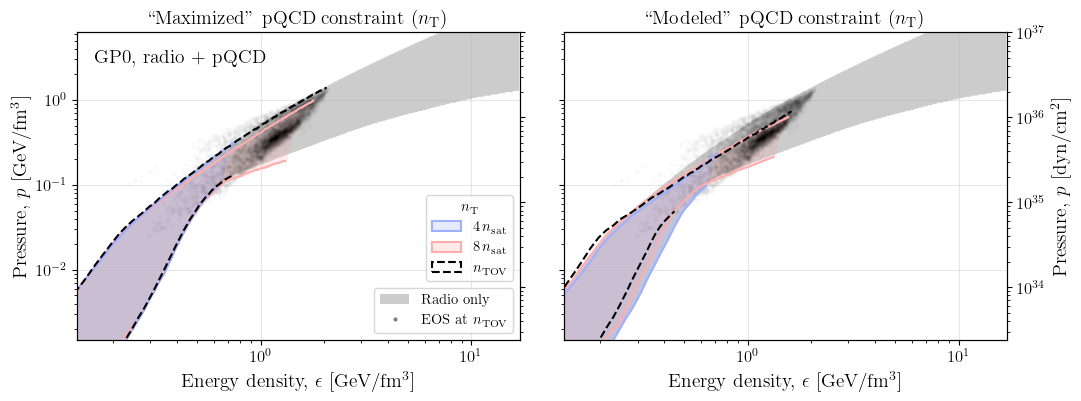

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# Radio only
# ----------

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio.csv')
)

q5 = quantiles.loc[5,:].values
q95 = quantiles.loc[95,:].values

for ax in axs:
    ax.fill_between(
        x_pe,
        q5,
        q95,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 1.5

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 0.8,
    8: 0.7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_radio_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv'
        )
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(
            '../data/eos-draws-default/quantiles/'
            f'p_of_eps_quantiles_radio_pqcd_{int(nterm):02}nsat_marg.csv'
        )
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

ntov_c = 'k'
lw = 1.5

# Max

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio_pqcd_ntov_Xmarg_mu2.6.csv'
    )
)

plot_quantiles(
    axs[0], 
    quantiles,
    x_pe,
    c=[0.,0.,0.],
    ls='--',
    lw=lw,
    x_cut=x_fit_dense_ntov,
    y_cut=y_fit_dense_ntov,
    alpha_scale=0,
    fill_alpha=0.0,
    line_zorder=11
)

# Marg

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(
        '../data/eos-draws-default/quantiles/p_of_eps_quantiles_radio_pqcd_ntov_marg.csv'
    )
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0.,0.,0.],
    ls='--',
    lw=lw,
    x_cut=x_fit_dense_ntov_extended,
    y_cut=y_fit_dense_ntov_extended,
    alpha_scale=0,
    fill_alpha=0.0,
    line_zorder=11
)

# GP prior at nTOV
# ----------------

for ax in axs:
    ax.plot(
        e_ntov, 
        p_ntov, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.02, 
        markeredgewidth=0,
        zorder=0.9,
        rasterized=True
    )

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=1.5,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4\,n_\mathrm{sat}$',
    '$8\,n_\mathrm{sat}$',
    '$n_\mathrm{TOV}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{T}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.17))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Radio only',
    'EOS at $n_\mathrm{TOV}$'
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(0.04, 0.9, 'GP0, radio + pQCD', transform=axs[0].transAxes)

# ---

for ax in axs:
    ax.set_xlim(xlim_pe)
    ax.set_ylim(ylim_pe)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($n_\mathrm{T}$)')
axs[1].set_title('``Modeled" pQCD constraint ($n_\mathrm{T}$)')

fig.savefig('figures/paper/radio_pqcd_e_p_posterior_nterm.pdf', bbox_inches='tight', dpi=300)